***
# <font color=forestgreen size=10>INTRODUÇÃO</font>

***
- Arquivo	: notebook.ipynb
- Título	: Exercício 4 - Disciplina de Redes Neurais Artificiais (DELT/UFMG)
- Autor	    : Gustavo Augusto Ortiz de Oliveira (gstvortiz@hotmail.com) <br> <br> <br>
- Descrição: 
A prática desta semana introduz Redes Neurais do tipo RBF (Radial Basis Functions), que são caracterizadas pela utilização de funções radiais nos neurônios de sua única camada intermediária. Similar às estruturas estudadas anteriormente, essas respostas são combinadas linearmente para a obtenção de saída da rede. De maneira geral, uma rede RBF pode ser descrita conforme equação:
$$  f(x,\theta) = \sum_{i=1}^{n}w_{i}h_{i}(x, z_{i})+w_{0} $$

Nesse contexto, temos que:
1. **$w_i$** é o vetor de parâmetros do neurônio de saída.
2. **$z_i$** é o vetor que contém todos os parâmetros do neurônio $i$ da camada intermediária.
3. **$\theta$** é o vetor que contém a concatenação de todos os parâmetros.



In [74]:
import os
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import pi as pi
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True, precision=3)

***
# <font color=royalblue size=10>CLASSES E FUNÇÕES</font>

***

## [1] FUNÇÃO NORMAL
$$  h(x, z_i) = e^{-\frac{x-\mu_i}{2r²}}$$

In [75]:
def normal(c, r):
    return lambda x: np.exp(-((x - np.array(c))**2).sum() / (2 * r**2))

## [2] CLASSE FIGURA

In [76]:
class Fig():
    def __init__(self, rows = 2, cols = 1, fs = (10, 7), xlim=(-15, 15), ylim=(-15, 15)):
        self.fig, axs  = plt.subplots(rows, cols, figsize=fs)
        self.axs = axs.ravel()
        self.rows = rows
        self.cols = cols        
        self.xlim = xlim
        self.ylim = ylim
        self.fns = dict()
        for ax in self.axs:
            ax.set_xlim(xlim)   
            ax.set_ylim(ylim) 

    def PlanoCartesiano(self, n = None):
        if n != None: 
            self.axs[n].spines['bottom'].set_position('zero')
            self.axs[n].spines['left'].set_position('zero')
            self.axs[n].spines['top'].set_visible(False)
            self.axs[n].spines['right'].set_visible(False)
        else:
            for i in range (len(self.axs)):
                self.PlanoCartesiano(i)
            return self
    
    def plotfn(self, n, fn, label, color, plot = sns.lineplot, gap = 0.01, style = 'dashed', c = 1):
        x = np.arange(self.xlim[0], self.xlim[1], gap)
        y = c*np.array([fn(Xi) for Xi in x])
        plot(x = x, y = y, ax = self.axs[n], linestyle = style, label = label, color = color)
        self.fns[label] = pd.DataFrame([x, y])

    def NetworkGrid(self, n, Neuronio, X, y, cmap, alpha):
        sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = y, ax = self.axs[n], palette = cmap, s = 80)
        eixo_x = np.linspace(self.xlim[0], self.xlim[1], 200)
        eixo_y = np.linspace(self.ylim[0], self.ylim[1], 200)
        xx, yy = np.meshgrid(eixo_x, eixo_y)
        pontos = np.column_stack((xx.ravel(), yy.ravel()))
        ŷ = Neuronio.predict(pontos).reshape(xx.shape)
        self.axs[n].contourf(xx, yy, ŷ, cmap=cmap, alpha=alpha)
        self.axs[n].set_title(f'Clusterização com {Neuronio.p} centros', pad = 15)

    def RemoveLabel(self):
        for ax in self.axs[:-1]:
            ax.get_legend().remove()

## [3] CLASSE RBF

In [77]:
class RBF:
    def __init__(self, X, p, labels = None, centros = None, raios = None):
        self.X = X
        self.p = p
        self.labels = labels
        self.centros = centros
        self.raios = raios
        self.w = None

    def KMeans(self, n_init, rf = np.mean):
        kmeans = KMeans(n_clusters=self.p, n_init=n_init).fit(self.X)
        self.labels = kmeans.labels_ 
        self.centros = kmeans.cluster_centers_
        self.raios = list()
        for cluster_id in range(self.p):
            cluster_points = self.X[self.labels == cluster_id]
            centro = self.centros[cluster_id]
            distancias_euclidianas = np.linalg.norm(cluster_points - centro, axis=1)
            self.raios.append(rf(distancias_euclidianas))
        return self.raios

    def H(self, X):
        N = X.shape[0]
        H = np.ones((N, self.p + 1))
        for i in range(N):
            for j in range(self.p):
                H[i, j] = normal(self.centros[j], self.raios[j])(X[i])
        return H

    def fit(self):
        self.w = np.linalg.pinv(self.H(self.X)).dot(self.labels)
    
    def predict(self, X):
        return self.H(X).dot(self.w)
    
    def GridVisualizer(self, fig, n, cmap = 'plasma', alpha = 0.5):
        return fig.NetworkGrid(n, self, self.X, self.labels, cmap = cmap, alpha = alpha)

***
# <font color=indianred size=10>APLICAÇÕES</font>

***

## [1] APROXIMAÇÃO DE FUNÇÕES (INCOMPLETO)

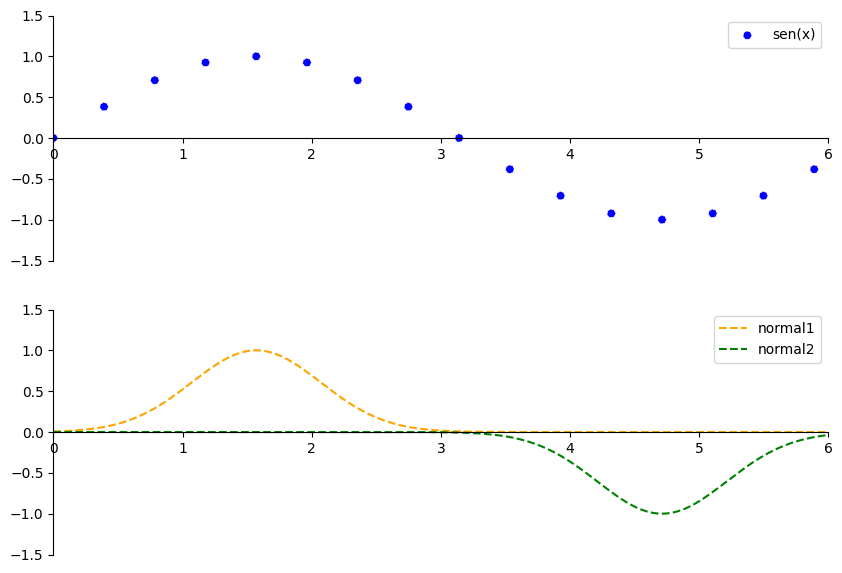

In [78]:
fig = Fig(2, 1, xlim = (0, 6), ylim = (-1.5, 1.5)).PlanoCartesiano()
fig.plotfn(0, np.sin, 'sen(x)', 'blue', sns.scatterplot, pi/8)
fig.plotfn(1, normal(pi/2, 0.5), 'normal1', 'orange')
fig.plotfn(1, normal(3*pi/2, 0.5), 'normal2', 'green', c = -1)

## [2] CLUSTERIZAÇÃO

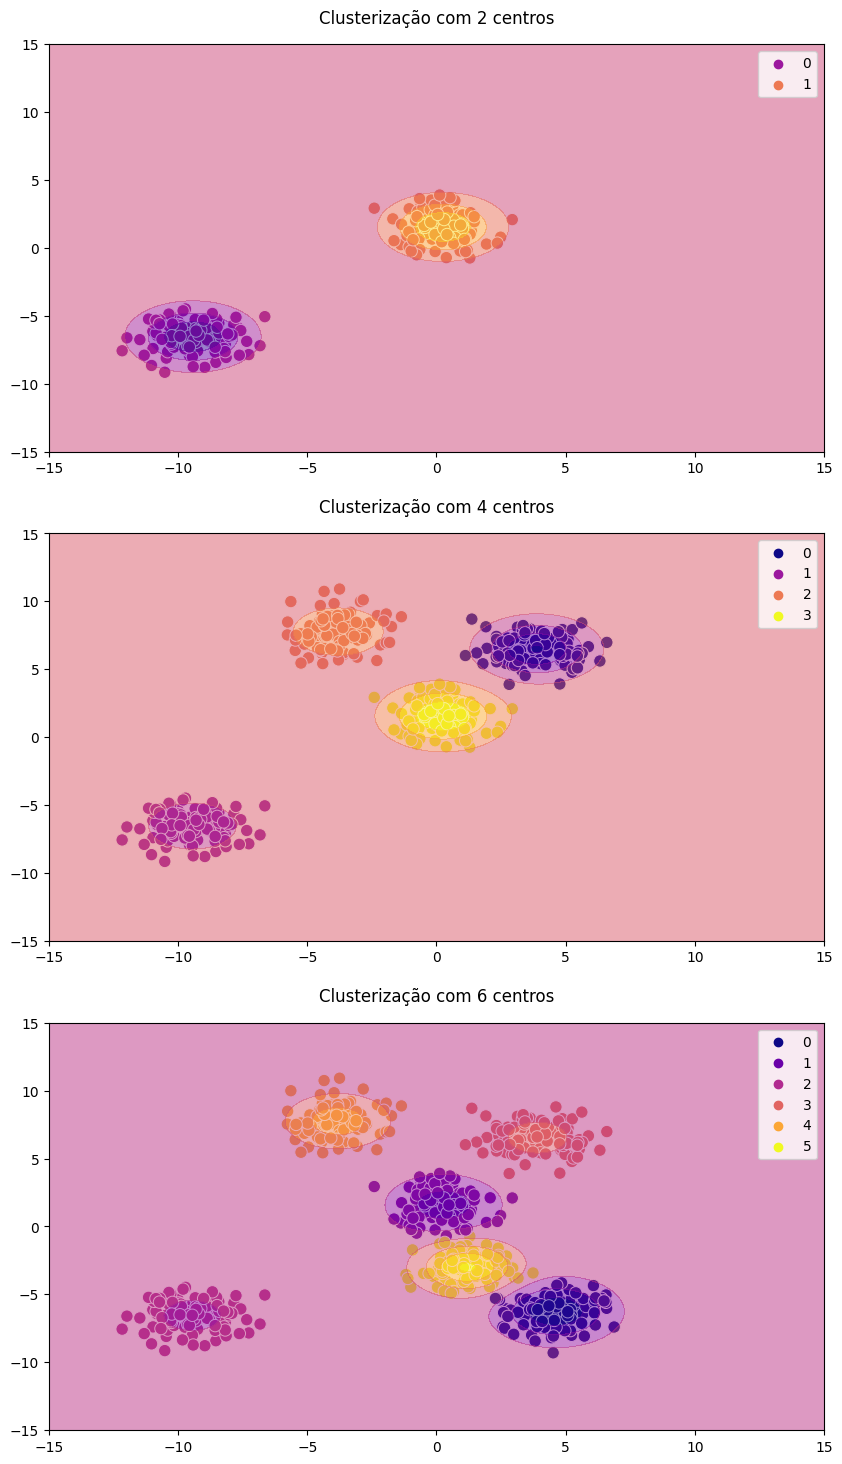

In [79]:
fig = Fig(3, 1, (10, 18))
for n, p in enumerate(range(2, 8, 2)):
    X, _ = make_blobs(n_samples=100*p, centers=p, random_state=101, shuffle=False) 
    Neuronio = RBF(X = X, p = p)
    Neuronio.KMeans(10*p)
    Neuronio.fit()
    Neuronio.GridVisualizer(fig, n)

***
# <font color=seablue size=10>EXERCÍCIO PROPOSTO</font>
*** 
<br>
<div align = 'center'> <img src = 'data/Enunciado.png'> </div> <br>

***

## [1]. IMPLEMENTAÇÃO

In [ ]:
# Importando as Amostras
dados = pd.read_csv('data/xor.csv')

# Preparação Preliminar
pasta = 'img'
os.makedirs(pasta)
scores, imagens, samples = list()

for sample in range(100, dados.shape[0]+1, 20):
    samples.append(sample)
    # Separando Dados
    data = dados.sample(sample)
    X, y = data.drop('y', axis = 1).values, data['y'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True, stratify=y)

    # Treinando o Modelo
    Neuronio = RBF(X = X_train, p = 4)
    Neuronio.KMeans(10*p)
    Neuronio.labels = y_train
    Neuronio.fit()

    # Realizando Previsões
    y_pred = Neuronio.predict(X_test)
    y_pred = np.round(y_pred)
    comp = y_pred == y_test
    scores.append(sum(comp)/len(comp))

    # Visualizando Resultados
    fig = Fig(2, 2, (16, 10), (-2, 2), (-2, 2))
    fig.axs[0].set_title(f'Dados de Treino ({len(y_train)})')
    sns.scatterplot(x = X_train[:, 0], y = X_train[:, 1], hue = y_train, ax = fig.axs[0])

    fig.axs[1].set_title(f'Dados de Teste ({len(y_test)})')
    sns.scatterplot(x = X_test[:, 0], y = X_test[:, 1], hue = y_test, ax = fig.axs[1], s = 80)

    fig.NetworkGrid(2, Neuronio, X_test, y_test, cmap = 'plasma', alpha = 0.7)
    fig.axs[2].set_title('Superfície de Separação Resultante')

    fig.axs[3].set_title('Precisão do Modelo por Amostra')
    fig.axs[3].set_xlabel('Número de Amostras')
    fig.axs[3].set_ylabel('Acertos (%)')
    sns.lineplot(scores, ax = fig.axs[3])
    fig.axs[3].set_xlim(0, len(scores))
    fig.axs[3].set_ylim(0.9, 1.01)
    fig.axs[3].set_xticklabels(samples)

    fig.RemoveLabel()

    # Gerando GIF
    plt.savefig(f'{pasta}/{sample}')
    plt.close()
    imagem = Image.open(os.path.join('img', f'{sample}.png'))
    imagens.append(imagem)
imagens[0].save('gif.gif', save_all=True, append_images=imagens[1:], duration=300, loop=0)
shutil.rmtree(pasta)

## [2]. RESULTADOS

<img src = "gif.gif">